In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
cd /content/drive/MyDrive/Colab Notebooks/Transfer Learning Cat and Dog

/content/drive/MyDrive/Colab Notebooks/Transfer Learning Cat and Dog


In [ ]:
# Download pretrained model Inception V3 from Google, just including params and weights
# Please run one time only
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O ./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-06-28 10:48:14--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

./inception_v3_weig 100%[===================>]  83.84M  49.3MB/s    in 1.7s    

2021-06-28 10:48:16 (49.3 MB/s) - ‘./inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [10]:
pwd

'/content/drive/MyDrive/Colab Notebooks/Transfer Learning Cat and Dog'

In [11]:
# Download the structure of InceptionV3 Deep Learning model, the above file contains only weights and biases
from tensorflow.keras.applications.inception_v3 import InceptionV3
local_weights_file = './inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [12]:
import os

In [13]:
from tensorflow.keras import layers, Model

In [14]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # scale each image to 150*150 pixels
                                include_top = False, # Delete the softmax and fully connected at the top
                                weights = None)
# inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 => "notop" means include_top = False => consistency

In [15]:
pre_trained_model.load_weights(local_weights_file)

In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_282 (Conv2D)             (None, 74, 74, 32)   864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_282 (BatchN (None, 74, 74, 32)   96          conv2d_282[0][0]                 
__________________________________________________________________________________________________
activation_282 (Activation)     (None, 74, 74, 32)   0           batch_normalization_282[0][0]    
_______________________________________________________________________________________

In [16]:
for layer in pre_trained_model.layers:
  layer.trainable = False

In [17]:
pre_trained_model.summary() # Non-trainable params: 21,802,784 => freeze all layers

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [18]:
last_layer = pre_trained_model.get_layer('mixed7') # (None, 7, 7, 768), anything before this layer will be freeze

In [19]:
last_output = last_layer.output

In [20]:
last_output

<KerasTensor: shape=(None, 7, 7, 768) dtype=float32 (created by layer 'mixed7')>

In [21]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to one dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification (because we just need 2 output labels)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x) # Create a new model with pre_trained_model as input 

In [22]:
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', # Computes the cross-entropy loss between true labels and predicted labels. Used for binary classification.
              metrics = ['acc'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

## Download cat-and-dog dataset from Google 

In [ ]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O ./cats_and_dogs_filtered.zip # the name of the file after downloading

--2021-06-28 12:56:30--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  48.4MB/s    in 1.4s    

2021-06-28 12:56:31 (48.4 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Add data-augumented params to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./225,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [25]:
# Note that the validation data should not be augmented
valid_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
!unzip -q cats_and_dogs_filtered.zip -d $'./' #unzip at the curret folder, run one time only

In [27]:
pwd

'/content/drive/My Drive/Colab Notebooks/Transfer Learning Cat and Dog'

In [28]:
# Look at the unziped folder to find the names
train_folder = './cats_and_dogs_filtered/train'
valid_folder = './cats_and_dogs_filtered/validation'

In [29]:
# Flow training images in batches of 20 using train_datagen generator from train_folder
train_generator = train_datagen.flow_from_directory(train_folder,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))
# Flow validation images in batches of 20 using valid_datagen generator from valid_folder
valid_generator = valid_datagen.flow_from_directory(valid_folder,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


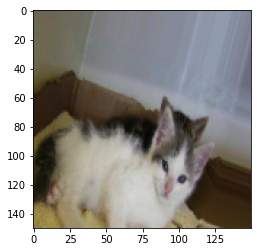

In [30]:
import matplotlib.pyplot as plt
plt.imshow(train_generator[13][0][7]) # the first index [0] includes both the images and labels, 
#the second one has all images, the last one is the index of an image

In [31]:
train_generator.class_indices

{'cats': 0, 'dogs': 1}

# The training process starts here

In [32]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator, 
                              steps_per_epoch=100, 
                              epochs=20, 
                              validation_steps=50, 
                              verbose=2)
# approximately 1 hour using normal CPU

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 - 539s - loss: 0.3573 - acc: 0.8630 - val_loss: 0.3492 - val_acc: 0.8760
Epoch 2/20
100/100 - 156s - loss: 0.2791 - acc: 0.8940 - val_loss: 0.0954 - val_acc: 0.9670
Epoch 3/20
100/100 - 158s - loss: 0.1951 - acc: 0.9190 - val_loss: 0.1821 - val_acc: 0.9440
Epoch 4/20
100/100 - 156s - loss: 0.2184 - acc: 0.9230 - val_loss: 0.1708 - val_acc: 0.9450
Epoch 5/20
100/100 - 158s - loss: 0.1795 - acc: 0.9370 - val_loss: 0.0943 - val_acc: 0.9630
Epoch 6/20
100/100 - 156s - loss: 0.1908 - acc: 0.9260 - val_loss: 0.1517 - val_acc: 0.9480
Epoch 7/20
100/100 - 155s - loss: 0.1880 - acc: 0.9300 - val_loss: 0.1227 - val_acc: 0.9620
Epoch 8/20
100/100 - 157s - loss: 0.1575 - acc: 0.9450 - val_loss: 0.1620 - val_acc: 0.9580
Epoch 9/20
100/100 - 155s - loss: 0.1691 - acc: 0.9430 - val_loss: 0.1249 - val_acc: 0.9690
Epoch 10/20
100/100 - 154s - loss: 0.1673 - acc: 0.9490 - val_loss: 0.1105 - val_acc: 0.9640
Epoch 11/20
100/100 - 165s - loss: 0.1471 - acc: 0.9510 - val_loss: 0.1165 - va

In [33]:
model.save("Transfer-Learning-Cats-Dogs.h5") # Save model so that you don't need to train the second time

In [38]:
# import the pretrained model above
import tensorflow as tf
saved_model = tf.keras.models.load_model("Transfer-Learning-Cats-Dogs.h5")

Upload full size images

Saving 02-cat-training-NationalGeographic_1484324.webp to 02-cat-training-NationalGeographic_1484324 (1).webp
Saving f57e00306f3183cc39fa919fec41418b.jpg to f57e00306f3183cc39fa919fec41418b (1).jpg


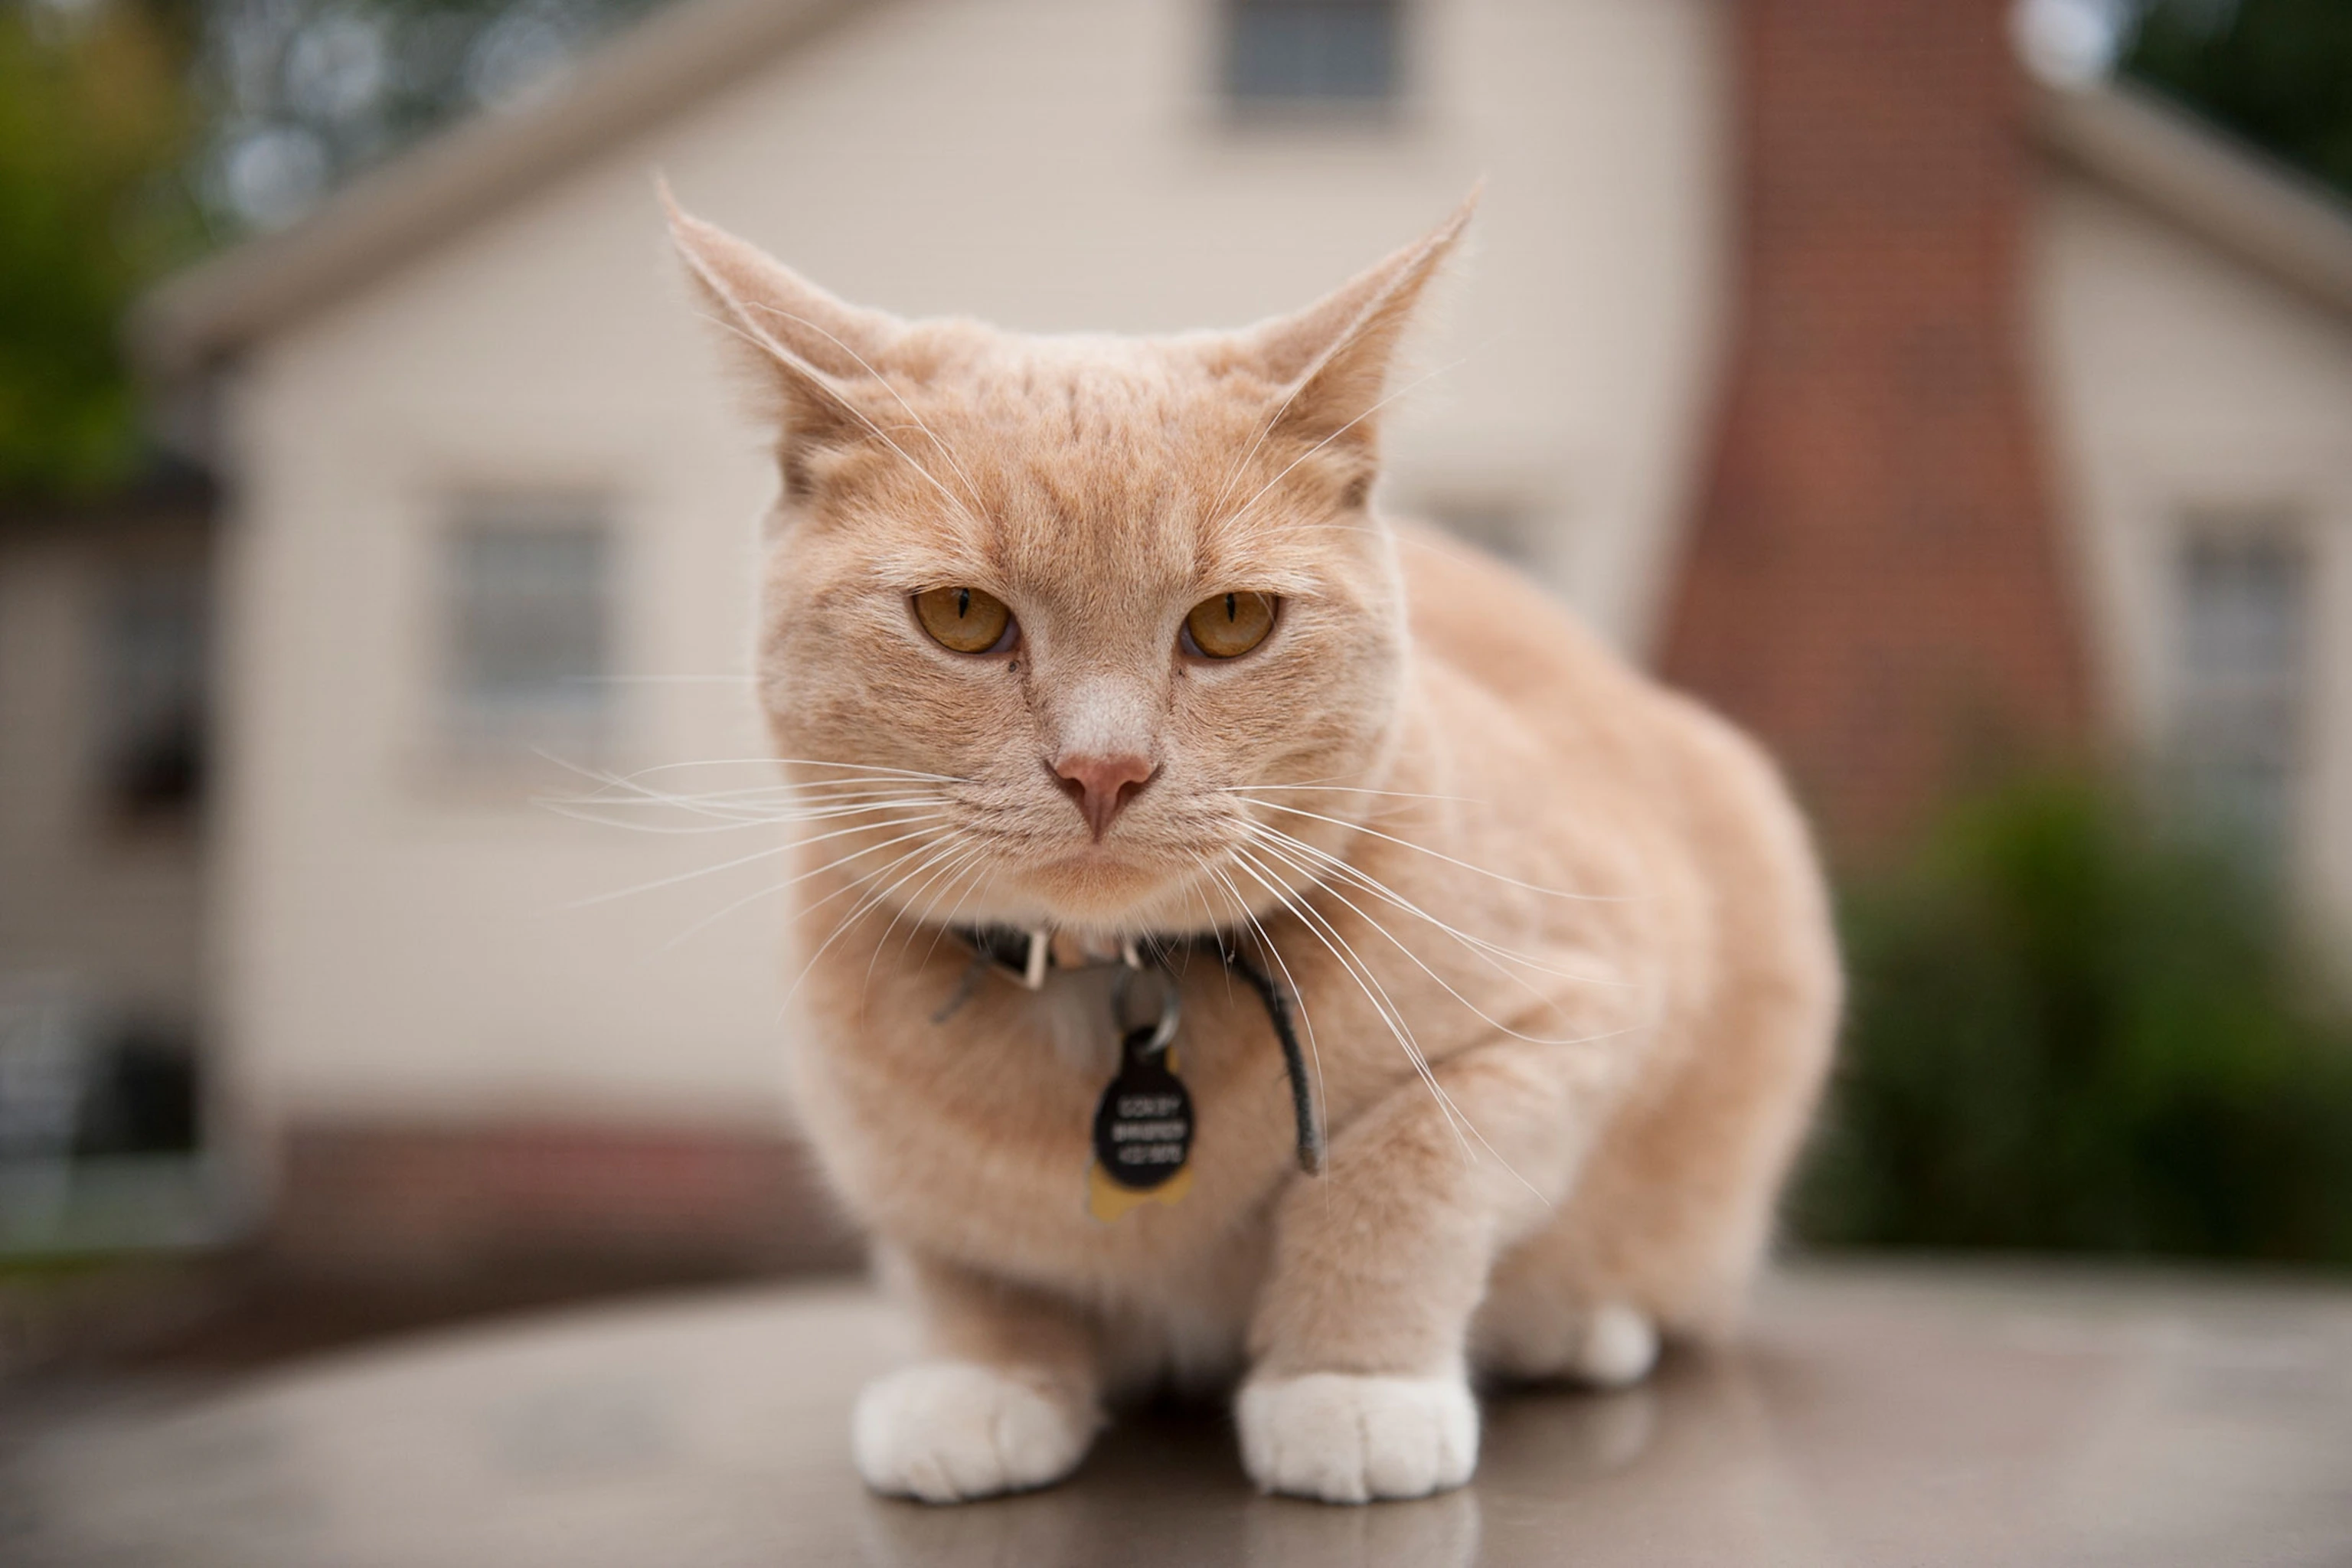

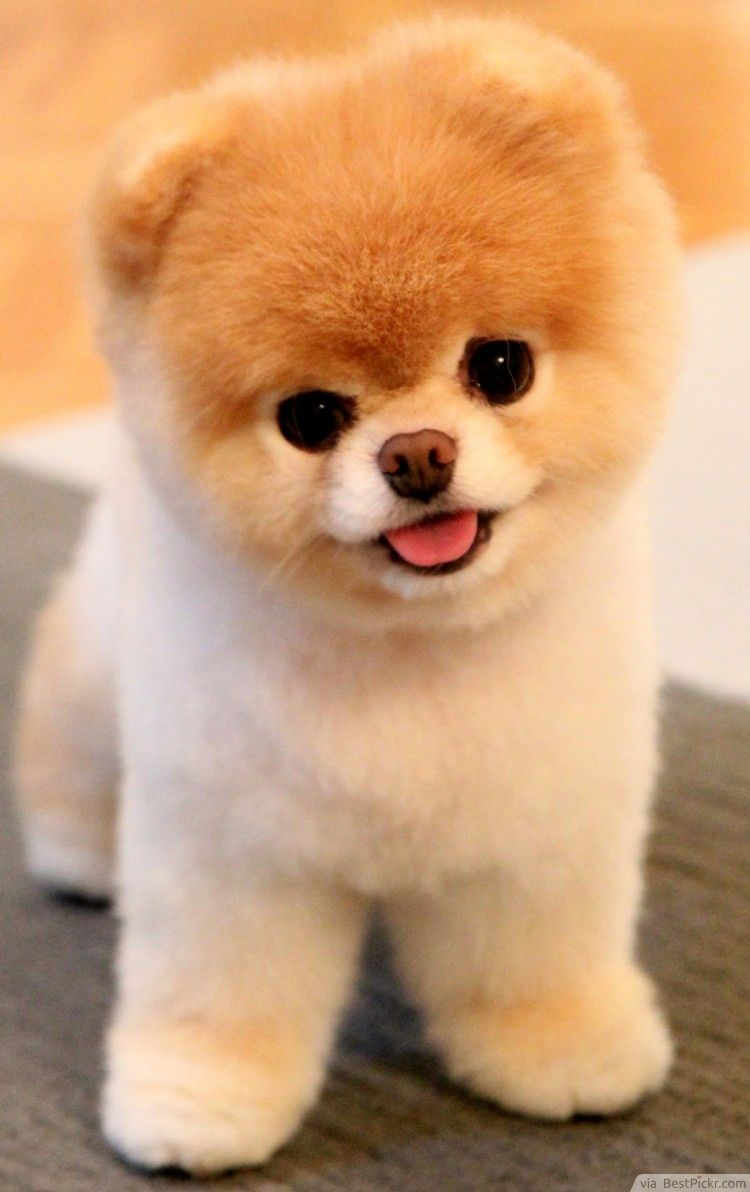

In [112]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Upload full sizes
uploaded = files.upload()

for image_name in uploaded.keys():
  path = './' + image_name
  img = cv2.imread(path)
  cv2_imshow(img)
  cv2.waitKey()

## Testing the model

Saving 02-cat-training-NationalGeographic_1484324.webp to 02-cat-training-NationalGeographic_1484324.webp
Saving 3180-Pug_green_grass-732x549-thumbnail.jpg to 3180-Pug_green_grass-732x549-thumbnail.jpg
Saving 67586673.jpg to 67586673.jpg
Saving 185634824_1067468527080670_2101910894100881559_n.png to 185634824_1067468527080670_2101910894100881559_n.png
Saving adorable-white-pomeranian-puppy-spitz-921029690-5c8be25d46e0fb000172effe.jpg to adorable-white-pomeranian-puppy-spitz-921029690-5c8be25d46e0fb000172effe.jpg
Saving download (1).jfif to download (1).jfif
Saving download.jfif to download.jfif
Saving f57e00306f3183cc39fa919fec41418b.jpg to f57e00306f3183cc39fa919fec41418b.jpg
1 is a cat.
2 is a dog.
3 is a cat.
4 is a dog.
5 is a cat.
6 is a cat.
7 is a cat.
8 is a cat.


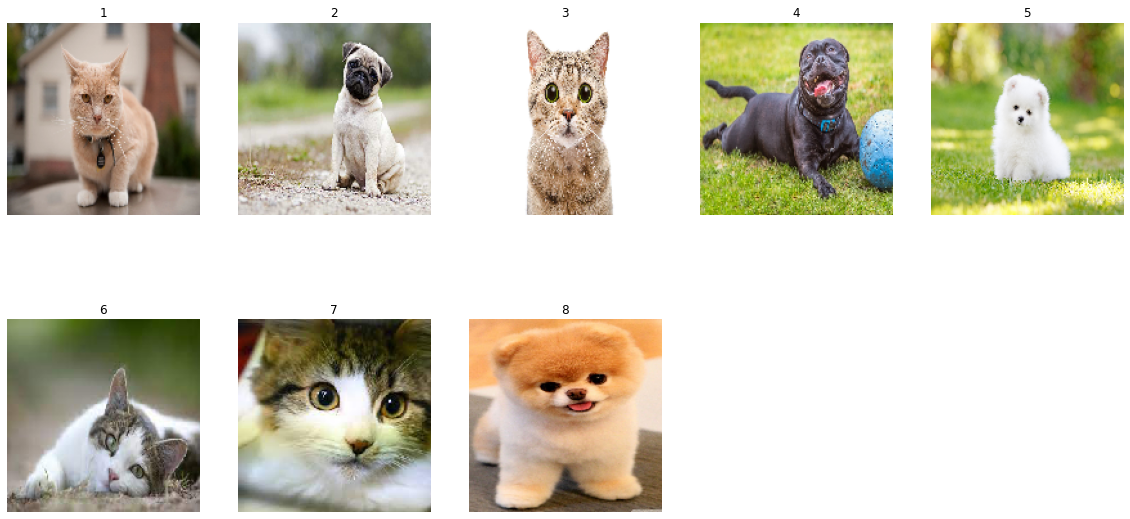

In [111]:
# code for displaying multiple images in one figure
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# Upload files
uploaded = files.upload()

# Create figure
fig = plt.figure(figsize=(20,10))
# setting values to rows and column variables
if len(uploaded.keys()) > 5: 
  if len(uploaded.keys()) % 5 == 0: rows = len(uploaded.keys()) / 5
  else: rows = len(uploaded.keys()) / 5 + 1
else: rows = 1
columns = 5

for i, image_name in enumerate(uploaded.keys()):
  path = './' + image_name
  img = image.load_img(path, target_size=(150, 150))
  fig.add_subplot(rows, columns, i+1)

  x = image.img_to_array(img) / 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = saved_model.predict(images, batch_size=10)

  if classes[0] > 0.5:
    print("%d is a dog." %(i+1))
  else:
    print("%d is a cat." %(i+1))

  # Showing image
  plt.imshow(img)
  plt.axis('off')
  plt.title(i+1)

Conclusion:

*   Correct: 6/8.
*   Wrong cases: 5, 8
*   Solution: Add more similar images of dogs to the train dataset
